In [ ]:
import os, glob, warnings
import numpy as np
import pandas as pd
from datetime import datetime
import subprocess, sys
import optuna
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import dalex as dx
import shap
import plotly.graph_objects as go
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'tensorflow.python'

In [ ]:
# 1. Load feature files and construct feature DataFrame
def load_feature_files(pattern="bulken_*.csv",
                       start="1961-01-01",
                       end="2021-01-01"):
    feature_files = sorted(glob.glob(pattern))
    if not feature_files:
        raise FileNotFoundError("No bulken_*.csv files found.")
    dates = pd.date_range(start=start, end=end, freq="D")
    feat_df = pd.DataFrame({"Date": dates})
    for f in feature_files:
        col_name = os.path.splitext(os.path.basename(f))[0]  # file name without .csv
        s = pd.read_csv(f, header=0)
        if s.shape[1] > 1:
            num_cols = [c for c in s.columns if np.issubdtype(s[c].dtype, np.number)]
            use_col = num_cols[0] if num_cols else s.columns[0]
            series = s[use_col]
        else:
            series = s.iloc[:,0]
        if len(series) != len(dates):
            raise ValueError(f"Length mismatch in {f}: {len(series)} vs {len(dates)} expected.")
        feat_df[col_name] = pd.to_numeric(series.values, errors="coerce")
    return feat_df

features_df = load_feature_files()

In [ ]:

# 2. Load target file and align
target_raw = pd.read_csv("BulkenDognVerdier.csv", skiprows=1, sep=";", header=0, engine="python")
target_raw.columns = [c.strip() for c in target_raw.columns]

date_col = "Tidspunkt"
target_col = "Vannføring"

target_raw[date_col] = pd.to_datetime(target_raw[date_col].str.replace("Z", "", regex=False), errors="coerce")
# Convert Norwegian decimal comma to dot and to float
target_raw[target_col] = (
    target_raw[target_col]
    .astype(str)
    .str.replace(",", ".", regex=False)
    .astype(float)
)

target_df = target_raw[[date_col, target_col]].rename(columns={date_col: "Date", target_col: "Vannføring"})
target_df["Date"] = target_df["Date"].dt.normalize()
mask = (target_df["Date"] >= features_df["Date"].min()) & (target_df["Date"] <= features_df["Date"].max())
target_df_daily = (
    target_df.loc[mask]
             .drop_duplicates(subset="Date")
             .reset_index(drop=True)
)

# Merge
merged = pd.merge(features_df, target_df_daily, on="Date", how="left")

print("features_df head:\n", features_df.head())
print("----------")
print("target_df_daily head:\n", target_df_daily.head())
print("----------")
print("merged head:\n", merged.head())

features_df head:
         Date  bulken_gwb_sssrel  bulken_rr  bulken_swe  bulken_tm
0 1961-01-01          31.295580        0.0  114.528361  -4.432103
1 1961-01-02          31.142726        0.0  114.497422  -4.394926
2 1961-01-03          31.152855        0.0  114.287937  -3.243727
3 1961-01-04          31.148250       34.6  114.194199  -3.645941
4 1961-01-05          30.985267        0.0  114.193831  -7.924631
----------
target_df_daily head:
         Date  Vannføring
0 1961-01-01    8.919145
1 1961-01-02    8.681128
2 1961-01-03    9.161231
3 1961-01-04    8.681128
4 1961-01-05    7.551074
----------
merged head:
         Date  bulken_gwb_sssrel  bulken_rr  bulken_swe  bulken_tm  Vannføring
0 1961-01-01          31.295580        0.0  114.528361  -4.432103    8.919145
1 1961-01-02          31.142726        0.0  114.497422  -4.394926    8.681128
2 1961-01-03          31.152855        0.0  114.287937  -3.243727    9.161231
3 1961-01-04          31.148250       34.6  114.194199  -3.64594

In [ ]:
# 3. Split by full years (80% train, rest test)
merged["Year"] = merged["Date"].dt.year
years = sorted(merged["Year"].unique())
year_counts = merged.groupby("Year").size()
full_years = [y for y in years if year_counts[y] >= 365]  # ignore leap detail
n_train_years = int(len(full_years) * 0.8)
train_years = full_years[:n_train_years]
test_years = full_years[n_train_years:]
train_df = merged[merged.Year.isin(train_years)].copy()
test_df = merged[merged.Year.isin(test_years)].copy()

feature_cols = [c for c in features_df.columns if c != "Date"]
X_train_raw = train_df[feature_cols].values
X_test_raw = test_df[feature_cols].values
y_train_raw = train_df["Vannføring"].values.reshape(-1,1)
y_test_raw = test_df["Vannføring"].values.reshape(-1,1)


In [ ]:
# 4. Scale
feat_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()
X_train_scaled = feat_scaler.fit_transform(X_train_raw)
X_test_scaled = feat_scaler.transform(X_test_raw)
y_train_scaled = target_scaler.fit_transform(y_train_raw)
y_test_scaled = target_scaler.transform(y_test_raw)


NameError: name 'MinMaxScaler' is not defined

In [ ]:
# 5. Sequence builder
def make_sequences(X, y, dates, lookback):
    X_seq, y_seq, end_dates = [], [], []
    for i in range(lookback, len(X)):
        X_seq.append(X[i-lookback:i])
        y_seq.append(y[i])
        end_dates.append(dates[i])
    return np.array(X_seq), np.array(y_seq), np.array(end_dates)

In [ ]:
# 6. Optuna tuning
def objective(trial):
    lookback = trial.suggest_int("lookback", 7, 60, step=7)
    units = trial.suggest_int("units", 16, 128, step=16)
    layers_n = trial.suggest_int("layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0.0, 0.4, step=0.1)
    lr = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    epochs = trial.suggest_int("epochs", 30, 80, step=10)
    X_train_seq, y_train_seq, _ = make_sequences(X_train_scaled, y_train_scaled, train_df["Date"].values, lookback)
    split = int(len(X_train_seq)*0.9)
    X_tr, X_val = X_train_seq[:split], X_train_seq[split:]
    y_tr, y_val = y_train_seq[:split], y_train_seq[split:]

    model = keras.Sequential()
    model.add(layers.Input(shape=(lookback, X_train_seq.shape[-1])))
    for li in range(layers_n):
        return_seq = li < layers_n - 1
        model.add(layers.LSTM(units, return_sequences=return_seq))
        if dropout > 0:
            model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                  loss="mse")
    es = keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, monitor="val_loss")
    model.fit(X_tr, y_tr, validation_data=(X_val, y_val),
              epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[es])
    val_pred = model.predict(X_val, verbose=0)
    mse = mean_squared_error(y_val, val_pred)
    return mse

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20, show_progress_bar=False)
best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2025-11-20 11:55:46,172] A new study created in memory with name: no-name-04afaa18-8968-4de8-a077-b37846017047
[I 2025-11-20 12:00:09,516] Trial 0 finished with value: 0.004608910438790471 and parameters: {'lookback': 42, 'units': 128, 'layers': 1, 'dropout': 0.4, 'lr': 0.00039152341774546323, 'batch_size': 64, 'epochs': 50}. Best is trial 0 with value: 0.004608910438790471.
[I 2025-11-20 12:01:01,196] Trial 1 finished with value: 0.004533434438497067 and parameters: {'lookback': 7, 'units': 128, 'layers': 1, 'dropout': 0.4, 'lr': 0.004349235086756002, 'batch_size': 128, 'epochs': 80}. Best is trial 1 with value: 0.004533434438497067.
[I 2025-11-20 12:03:02,741] Trial 2 finished with value: 0.004324685732210537 and parameters: {'lookback': 28, 'units': 48, 'layers': 3, 'dropout': 0.1, 'lr': 0.0039430890954176194, 'batch_size': 128, 'epochs': 80}. Best is trial 2 with value: 0.004324685732210537.
[I 2025-11-20 12:07:18,240] Trial 3 finished with value: 0.004576475889265653 and parame

Best hyperparameters: {'lookback': 21, 'units': 32, 'layers': 3, 'dropout': 0.1, 'lr': 0.00478055405042448, 'batch_size': 32, 'epochs': 40}


Do not run above code, it takes ~110 minutes.

[I 2025-11-14 11:55:46,172] A new study created in memory with name: no-name-04afaa18-8968-4de8-a077-b37846017047
[I 2025-11-14 12:00:09,516] Trial 0 finished with value: 0.004608910438790471 and parameters: {'lookback': 42, 'units': 128, 'layers': 1, 'dropout': 0.4, 'lr': 0.
[I 2025-11-14 13:43:00,488] Trial 19 finished with value: 0.004411569388362407 and parameters: {'lookback': 7, 'units': 96, 'layers': 3, 'dropout': 0.0, 'lr': 0.00275401592713366, 'batch_size': 32, 'epochs': 40}. Best is trial 17 with value: 0.00420131900560965.

Best hyperparameters: {'lookback': 21, 'units': 32, 'layers': 3, 'dropout': 0.1, 'lr': 0.00478055405042448, 'batch_size': 32, 'epochs': 40}

In [ ]:
# 7. Build final model (hard-coded best hyperparameters)
best_params = {'lookback': 21, 'units': 32, 'layers': 3, 'dropout': 0.1,
               'lr': 0.00478055405042448, 'batch_size': 32, 'epochs': 40}
lookback = best_params['lookback']
X_train_seq, y_train_seq, train_seq_dates = make_sequences(
    X_train_scaled, y_train_scaled, train_df["Date"].values, lookback)
X_test_seq, y_test_seq, test_seq_dates = make_sequences(
    X_test_scaled, y_test_scaled, test_df["Date"].values, lookback)
model = keras.Sequential()
model.add(layers.Input(shape=(lookback, X_train_seq.shape[-1])))
for li in range(best_params['layers']):
    return_seq = li < best_params['layers'] - 1
    model.add(layers.LSTM(best_params['units'], return_sequences=return_seq))
    if best_params['dropout'] > 0:
        model.add(layers.Dropout(best_params['dropout']))
model.add(layers.Dense(1))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=best_params['lr']), loss="mse")
es = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_loss")
model.fit(X_train_seq, y_train_seq,
          epochs=best_params['epochs'],
          batch_size=best_params['batch_size'],
          validation_split=0.1, verbose=0, callbacks=[es])

In [ ]:
# 8. Predictions + metrics
y_pred_scaled = model.predict(X_test_seq, verbose=0)
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_true = target_scaler.inverse_transform(y_test_seq)
r2 = r2_score(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mad = np.median(np.abs(y_true - y_pred))
print(f"R2: {r2:.4f}  MSE: {mse:.4f}  RMSE: {rmse:.4f}  MAD: {mad:.4f}")

R2: 0.7675  MSE: 1440.1046  RMSE: 37.9487  MAD: 12.1096


In [ ]:
# 9. Prepare flattened feature matrix for DALEX (each lag as separate column)
def flatten_sequences(X_seq, feature_names):
    n_samples, lb, n_feat = X_seq.shape
    cols = []
    for lag in range(lb):
        for f in feature_names:
            cols.append(f"{f}_lag{lb-lag}")  # lag numbering: nearest future smaller number
    flat = X_seq.reshape(n_samples, lb*n_feat)
    return pd.DataFrame(flat, columns=cols)

X_test_flat_df = flatten_sequences(X_test_seq, feature_cols)
y_true_series = pd.Series(y_true.flatten(), name="Vannføring", index=X_test_flat_df.index)

In [ ]:
# 10. DALEX explainer 
def predict_fn(model, x):
    if isinstance(x, pd.DataFrame):
        x = x.values

    arr = np.asarray(x)
    samples, cols = arr.shape

    expected_cols = lookback * len(feature_cols)
    if cols != expected_cols:
        raise ValueError(
            f"predict_fn: expected {expected_cols} columns "
            f"(= {lookback} * {len(feature_cols)}), got {cols}."
        )
    arr3d = arr.reshape(samples, lookback, len(feature_cols))
    preds_scaled = model.predict(arr3d, verbose=0)
    return target_scaler.inverse_transform(preds_scaled).ravel()

explainer = dx.Explainer(model=model,
                         data=X_test_flat_df,
                         y=y_true_series,
                         model_type="regression",
                         label="LSTM",
                         predict_function=predict_fn)

try:
    vi = explainer.model_parts(N=500, random_state=42)
except Exception as e:
    raise RuntimeError(f"model_parts failed: {e}")
print(vi.result.head())

Preparation of a new explainer is initiated

  -> data              : 4362 rows 105 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 4362 values
  -> model_class       : keras.src.models.sequential.Sequential (default)
  -> label             : LSTM
  -> predict function  : <function predict_fn at 0x00000197EC6DB880> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 2.83, mean = 78.8, max = 4.25e+02
  -> model type        : regression will be used
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -1.64e+02, mean = -2.72, max = 4.43e+02
  -> model_info        : package keras

A new explainer has been created!
           variable  dropout_loss label
0  bulken_swe_lag10     37.966752  LSTM
1   bulken_swe_lag8     37.971549  LSTM
2  bulken_swe_lag12     37.997325  LSTM
3   bulken_swe_lag9     38.059872  LSTM
4  bu

Selected year 2015 with 365 sequences.


  0%|          | 0/365 [00:00<?, ?it/s]

SHAP daily shape: (365, 5)


ValueError: The number of FixedLocator locations (12), usually from a call to set_ticks, does not match the number of labels (13).

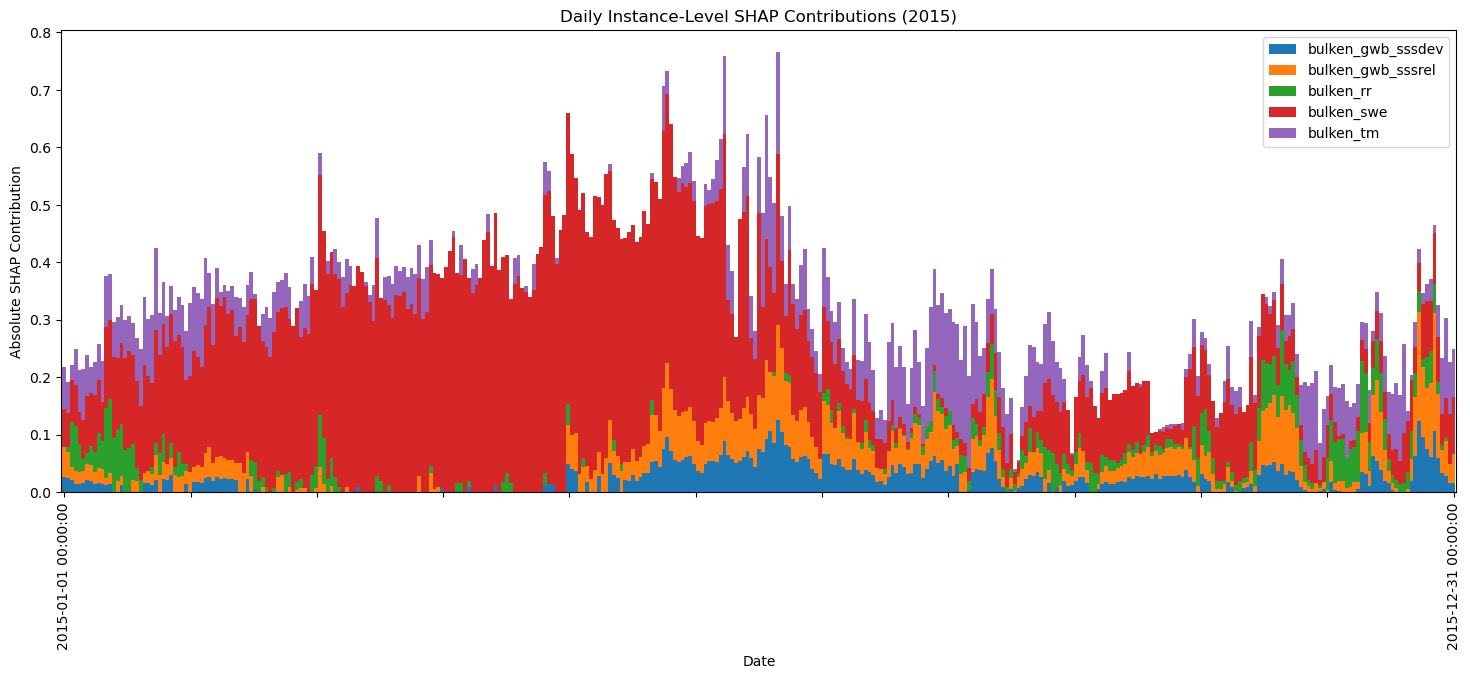

In [ ]:
# 11. SHAP for 1 year
all_dates = pd.to_datetime(test_seq_dates)
all_dates_s = pd.Series(all_dates)  
years_available = sorted(all_dates_s.dt.year.unique())
year_for_plot = years_available[len(years_available)//2]
mask_year_full = all_dates_s.dt.year == year_for_plot
X_year = X_test_seq[mask_year_full.to_numpy()]
dates_year = all_dates_s[mask_year_full].reset_index(drop=True)

print(f"Selected year {year_for_plot} with {len(X_year)} sequences.")

sample_size = len(X_year)
X_shap_sample = X_year 
X_bg_flat = background.reshape(background.shape[0], -1)
X_sample_flat = X_shap_sample.reshape(sample_size, -1)
f = lambda x: model.predict(
    x.reshape((-1, lookback, len(feature_cols))),
    verbose=0
)
explainer = shap.KernelExplainer(f, X_bg_flat)
shap_flat = explainer.shap_values(X_sample_flat)
shap_values = np.array(shap_flat).reshape(
    sample_size, lookback, len(feature_cols)


shap_daily = np.abs(shap_values).sum(axis=1)

df = pd.DataFrame(shap_daily, columns=feature_cols, index=dates_year)

print("SHAP daily shape:", df.shape)

In [ ]:
# 12. Plotting SHAP  

df_scaled = df.copy()  
for i, pred in enumerate(y_pred_year):
    shap_sum = df.iloc[i].sum()
    if shap_sum != 0:
        scale_factor = pred / shap_sum
        df_scaled.iloc[i] = df.iloc[i] * scale_factor
    else:
        df_scaled.iloc[i] = df.iloc[i] 


fig = go.Figure()
x = df.index  

fig.add_trace(go.Scatter(
    x=x,
    y=y_pred_year,
    mode="lines",
    name="Predicted",
    line=dict(width=2, color="red"),
    hovertemplate="<b>%{x|%Y-%m-%d}</b><br>Predicted: %{y:.2f}<extra></extra>"
))

fig.add_trace(go.Scatter(
    x=x,
    y=y_true_year,
    mode="lines",
    name="True",
    line=dict(width=2, dash="dot", color="black"),
    hovertemplate="<b>%{x|%Y-%m-%d}</b><br>True: %{y:.2f}<extra></extra>"
))

colors = ['#d62728', '#2ca02c','#1f77b4', '#ff7f0e', '#9467bd', '#8c564b'] 

for i, feat in enumerate(df_scaled.columns):
    fig.add_trace(go.Bar(
        x=x,
        y=df_scaled[feat],
        name=feat,
        opacity=0.9,
        marker=dict(
            color=colors[i % len(colors)],
            line=dict(width=0)  
        ),
        hovertemplate="<b>%{x|%Y-%m-%d}</b><br>" + feat + ": %{y:.2f}<extra></extra>"
    ))

fig.update_layout(
    title=f"Daily SHAP Contributions Scaled to Prediction ({year_for_plot})",
    barmode="relative",  
    xaxis_title="Date",
    yaxis_title="Value / SHAP Contribution",
    hovermode="x unified",
    height=600,
    legend=dict(orientation="h")
)

fig.update_xaxes(dtick="M1", tickformat="%b")
fig.update_yaxes(range=[-100, 450])
fig.update_layout(height=1050, width=1300)


fig.show()

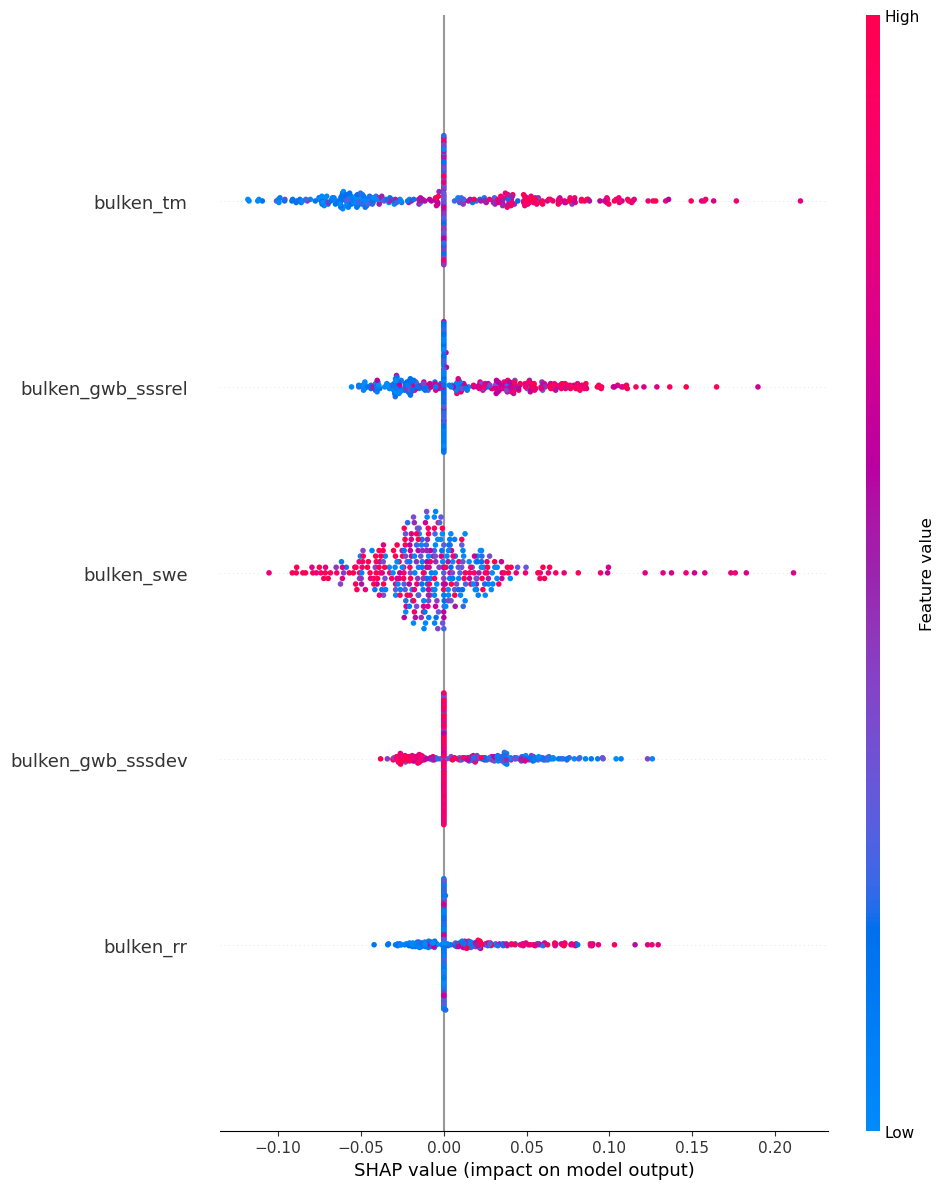

In [ ]:
# 13. Beeswarm plot of the data above 
X_feat_mean_year = X_year.mean(axis=1)  # (samples, features)
df_features = pd.DataFrame(X_feat_mean_year, columns=feature_cols, index=dates_year)
shap_values_for_plot = df.values  # (samples, features)
try:
    shap.summary_plot(
        shap_values_for_plot,
        df_features,
        show=True,
        plot_size=(10, 12)  # width, height in inches
    )
except Exception as e:
    warnings.warn(f"summary_plot failed: {e}")

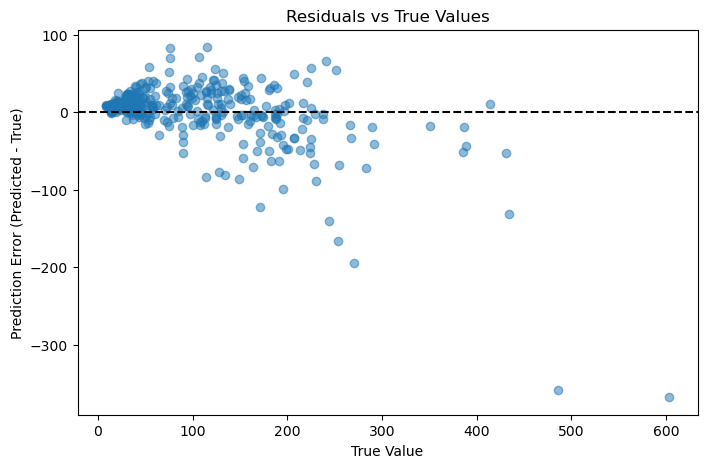

In [ ]:
# 13. Compute errors
errors = y_pred_year - y_true_year  # signed error
abs_errors = np.abs(errors)         # magnitude

plt.figure(figsize=(8,5))
plt.scatter(y_true_year, errors, alpha=0.5)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("True Value")
plt.ylabel("Prediction Error (Predicted - True)")
plt.title("Residuals vs True Values")
plt.show()


Correlation matrix (bulken_ features):
                   bulken_gwb_sssdev  bulken_gwb_sssrel  bulken_rr  \
bulken_gwb_sssdev           1.000000          -0.982258  -0.288421   
bulken_gwb_sssrel          -0.982258           1.000000   0.324284   
bulken_rr                  -0.288421           0.324284   1.000000   
bulken_swe                  0.149811          -0.095685  -0.005465   
bulken_tm                  -0.383842           0.320537   0.027963   

                   bulken_swe  bulken_tm  
bulken_gwb_sssdev    0.149811  -0.383842  
bulken_gwb_sssrel   -0.095685   0.320537  
bulken_rr           -0.005465   0.027963  
bulken_swe           1.000000  -0.324593  
bulken_tm           -0.324593   1.000000  


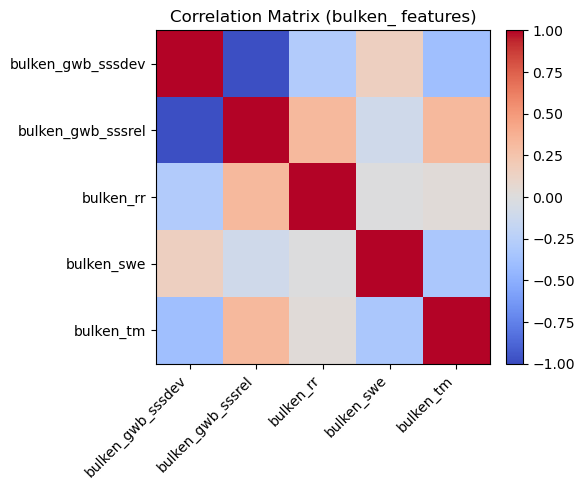

In [99]:
# Correlation matrix for bulken_ features
bulken_cols = [c for c in merged.columns if c.startswith("bulken_")]
if not bulken_cols:
    raise ValueError("No columns starting with 'bulken_' found in merged dataframe.")

corr = merged[bulken_cols].corr()
print("Correlation matrix (bulken_ features):")
print(corr)

# Optional heatmap
plt.figure(figsize=(6,5))
im = plt.imshow(corr.values, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(bulken_cols)), bulken_cols, rotation=45, ha="right")
plt.yticks(range(len(bulken_cols)), bulken_cols)
plt.title("Correlation Matrix (bulken_ features)")
plt.tight_layout()
plt.show()